# Predicting category of consumer complaint

### Text Classification using Logistic Regression, Random Forest, SVM, Naive Bayes, LSTM

Given a consumer complaint narrative, the model attempts to predict which product the complaint is about. This includes extracting top product categories and creating an ML model to classify the complaints (based on their descriptions) into one of these categories. I also predicted the category for new unseen complaints. 

In [1]:
import pandas as pd
df = pd.read_csv('/content/consumer_complaints.csv')
df.info()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555957 entries, 0 to 555956
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   date_received                 555957 non-null  object
 1   product                       555957 non-null  object
 2   sub_product                   397635 non-null  object
 3   issue                         555957 non-null  object
 4   sub_issue                     212622 non-null  object
 5   consumer_complaint_narrative  66806 non-null   object
 6   company_public_response       85124 non-null   object
 7   company                       555957 non-null  object
 8   state                         551070 non-null  object
 9   zipcode                       551452 non-null  object
 10  tags                          77959 non-null   object
 11  consumer_consent_provided     123458 non-null  object
 12  submitted_via                 555957 non-null  object
 13 

In [2]:
df['product'].value_counts()

Mortgage                   186475
Debt collection            101052
Credit reporting            91854
Credit card                 66468
Bank account or service     62563
Consumer Loan               20990
Student loan                15839
Payday loan                  3877
Money transfers              3812
Prepaid card                 2470
Other financial service       557
Name: product, dtype: int64

#### Feature Engineering

1. Consolidate “Credit reporting” into “Credit reporting, credit repair services, or other personal consumer reports”.
2. Consolidate “Credit card” into “Credit card or prepaid card”.
3. Consolidate “Payday loan” into “Payday loan, title loan, or personal loan”.
4. Consolidate “Virtual currency” into “Money transfer, virtual currency, or money service”.
5. Remove “Other financial service” 

In [3]:
df.loc[df['product'] == 'Credit reporting', 'product'] = 'Credit reporting, credit repair services, or other personal consumer reports'
df.loc[df['product'] == 'Credit card', 'product'] = 'Credit card or prepaid card'
df.loc[df['product'] == 'Payday loan', 'product'] = 'Payday loan, title loan, or personal loan'
df.loc[df['product'] == 'Virtual currency', 'product'] = 'Money transfer, virtual currency, or money service'
df = df[df['product'] != 'Other financial service']
df.shape

(555400, 18)

In [4]:
df = df[df['consumer_complaint_narrative'].notna()]
df.shape

(66696, 18)

<BarContainer object of 10 artists>

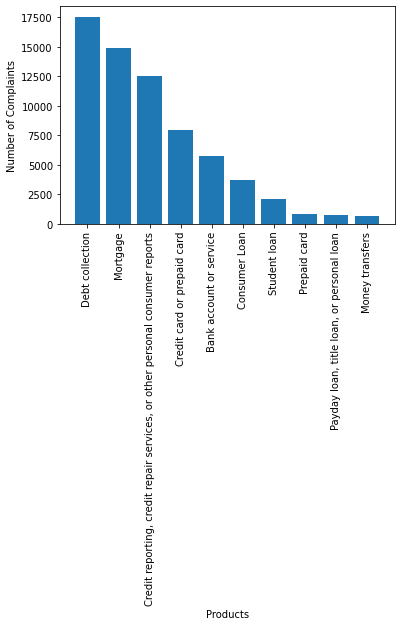

In [5]:
import matplotlib.pyplot as plt

products = df['product'].value_counts().sort_values(ascending=False)
plt.ylabel('Number of Complaints')
plt.xlabel('Products')
plt.xticks(rotation='90')
plt.bar(products.index, products.values)

To train supervised classifiers, we first transformed the “Consumer complaint narrative” into a vector of numbers. 
We then explore vector representations such as TF-IDF weighted vectors.

In [6]:
df['category_id'] = df['product'].factorize()[0]
category_id_df = df[['product', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'product']].values)
df.head()

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id,category_id
190126,03/19/2015,Debt collection,"Other (i.e. phone, health club, etc.)",Cont'd attempts collect debt not owed,Debt was paid,XXXX has claimed I owe them {$27.00} for XXXX ...,NaN,"Diversified Consultants, Inc.",NY,121XX,Older American,Consent provided,Web,03/19/2015,Closed with explanation,Yes,No,1290516,0
190135,03/19/2015,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,Due to inconsistencies in the amount owed that...,NaN,M&T Bank Corporation,VA,221XX,Servicemember,Consent provided,Web,03/19/2015,Closed with explanation,Yes,No,1290492,1
190155,03/19/2015,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",NaN,In XX/XX/XXXX my wages that I earned at my job...,NaN,Wells Fargo & Company,CA,946XX,NaN,Consent provided,Web,03/19/2015,Closed with explanation,Yes,Yes,1290524,2
190207,03/19/2015,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account",NaN,I have an open and current mortgage with Chase...,NaN,JPMorgan Chase & Co.,CA,900XX,Older American,Consent provided,Web,03/19/2015,Closed with explanation,Yes,Yes,1290253,2
190208,03/19/2015,Mortgage,Conventional fixed mortgage,Credit decision / Underwriting,NaN,XXXX was submitted XX/XX/XXXX. At the time I s...,NaN,Rushmore Loan Management Services LLC,CA,956XX,Older American,Consent provided,Web,03/19/2015,Closed with explanation,Yes,Yes,1292137,2


In [21]:
category_id_df.head()

,product,category_id
190126,Debt collection,0
190135,Consumer Loan,1
190155,Mortgage,2
190263,Credit card or prepaid card,3
191477,"Credit reporting, credit repair services, or o...",4


In [12]:
df = df.head(6000)

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.consumer_complaint_narrative).toarray()
labels = df.category_id
features.shape

(6000, 16588)

Now, each of the 6000 consumer complaint narratives is represented by 16588 features, representing the tf-idf score for different unigrams and bigrams. We can use sklearn.feature_selection.chi2 to find the terms that are the most correlated with each of the products.

In [14]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Bank account or service':
  . Most correlated unigrams:
. branch
. overdraft
  . Most correlated bigrams:
. checking account
. debit card
# 'Consumer Loan':
  . Most correlated unigrams:
. car
. vehicle
  . Most correlated bigrams:
. vehicle xxxx
. auto finance
# 'Credit card or prepaid card':
  . Most correlated unigrams:
. express
. card
  . Most correlated bigrams:
. annual fee
. credit card
# 'Credit reporting, credit repair services, or other personal consumer reports':
  . Most correlated unigrams:
. experian
. equifax
  . Most correlated bigrams:
. report xxxx
. credit report
# 'Debt collection':
  . Most correlated unigrams:
. collection
. debt
  . Most correlated bigrams:
. collect debt
. collection agency
# 'Money transfers':
  . Most correlated unigrams:
. paypal
. wire
  . Most correlated bigrams:
. wire transfer
. western union
# 'Mortgage':
  . Most correlated unigrams:
. modification
. mortgage
  . Most correlated bigrams:
. mortgage company
. loan modification
# 'Pay

Naive Bayes Classifier

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(df['consumer_complaint_narrative'], df['product'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)
print(clf.predict(count_vect.transform(["This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."])))
print(clf.predict(count_vect.transform(["I am disputing the inaccurate information the Chex-Systems has on my credit report. I initially submitted a police report on XXXX/XXXX/16 and Chex Systems only deleted the items that I mentioned in the letter and not all the items that were actually listed on the police report. In other words they wanted me to say word for word to them what items were fraudulent. The total disregard of the police report and what accounts that it states that are fraudulent. If they just had paid a little closer attention to the police report I would not been in this position now and they would n't have to research once again. I would like the reported information to be removed : XXXX XXXX XXXX"])))

['Debt collection']
['Credit reporting, credit repair services, or other personal consumer reports']


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [16]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.828167
LogisticRegression        0.802500
MultinomialNB             0.661833
RandomForestClassifier    0.448833
Name: accuracy, dtype: float64

Not surprisingly, SVM does best at multi-class classification with accuracy at 0.82

Now, let us look at the misclassifications

In [25]:
from IPython.display import display
for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 10:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['product', 'consumer_complaint_narrative']])
      print('')

'Consumer Loan' predicted as 'Debt collection' : 20 examples.


,product,consumer_complaint_narrative
203591,Consumer Loan,I had a car loan with Lobel Financial and beca...
217275,Consumer Loan,One Main financial will not stop calling me at...
214362,Consumer Loan,My complaint is about telephone calls to me fr...
217535,Consumer Loan,I took out a loan of {$3100.00} from Loan Me. ...
212964,Consumer Loan,I have informed the Company I am not allowed t...
209810,Consumer Loan,"More than a decade ago, I began receiving debt..."
215464,Consumer Loan,"First off the loan agent, looks up my family m..."
201989,Consumer Loan,In XX/XX/XXXX I was mailed a check and paperwo...
212061,Consumer Loan,I have XXXX cases with you on the same conflic...
218204,Consumer Loan,I tried several times to change my loan 's dir...



'Credit card or prepaid card' predicted as 'Debt collection' : 25 examples.


,product,consumer_complaint_narrative
220987,Credit card or prepaid card,An auto-dialer operated by or on behalf of Cap...
213034,Credit card or prepaid card,USAA did not follow procedures when they proce...
203553,Credit card or prepaid card,Ordered a First Progress Credit and submitted ...
213882,Credit card or prepaid card,"While serving in the United States XXXX, I rec..."
217400,Credit card or prepaid card,I notified Tjmaxx months ago that I had retain...
214742,Credit card or prepaid card,I received a collection letter from First Nati...
210959,Credit card or prepaid card,I have been contacted by XXXX LLC via letter. ...
200811,Credit card or prepaid card,OneMain Financial called my place of business ...
205969,Credit card or prepaid card,I keep getting a robo call ( XXXX ) threatenin...
208380,Credit card or prepaid card,My credit card company ( Citi ) contacted a pe...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Debt collection' : 36 examples.


,product,consumer_complaint_narrative
199495,"Credit reporting, credit repair services, or o...",I have recently pulled out my credit profile f...
219046,"Credit reporting, credit repair services, or o...",I have sent sign receipt requested to a collec...
209676,"Credit reporting, credit repair services, or o...",ive asked for a signed contract they will not ...
207363,"Credit reporting, credit repair services, or o...","For the past 2 years, I have disputed XXXX acc..."
209332,"Credit reporting, credit repair services, or o...",I 'm trying to see my credit reports \n
210276,"Credit reporting, credit repair services, or o...","XXXX account # XXXX I have insurance, I paid m..."
215259,"Credit reporting, credit repair services, or o...",XXXX and XXXX XXXX XXXX are on my credit repor...
210039,"Credit reporting, credit repair services, or o...",I have a debt on my credit report with XXXX Mo...
197095,"Credit reporting, credit repair services, or o...","I paid off my debt 100 % almost a year ago, ye..."
216542,"Credit reporting, credit repair services, or o...","XXXX has filed a "" Collections Account '' on m..."



'Payday loan, title loan, or personal loan' predicted as 'Debt collection' : 14 examples.


,product,consumer_complaint_narrative
216062,"Payday loan, title loan, or personal loan",I have received a call from XXXX XXXX XXXX XXX...
205760,"Payday loan, title loan, or personal loan",Several of the categories above apply : - Frau...
218321,"Payday loan, title loan, or personal loan",I had a loan with Cash Net three years ago. My...
221003,"Payday loan, title loan, or personal loan",I filed a complaint against Ace Cash Express a...
207432,"Payday loan, title loan, or personal loan",I received a payday loan in 2013 ... .circumst...
213247,"Payday loan, title loan, or personal loan",The company Cash Central called me on XXXX/XXX...
211513,"Payday loan, title loan, or personal loan",California Budget Finance. XXXX XXXX XXXX XXXX...
210172,"Payday loan, title loan, or personal loan",I want the creditor Bryant & Bryant to stop co...
194507,"Payday loan, title loan, or personal loan",I have been approached by Concord Resolution (...
214268,"Payday loan, title loan, or personal loan",I received a payday loan over 7 years ago from...



'Debt collection' predicted as 'Mortgage' : 12 examples.


,product,consumer_complaint_narrative
198640,Debt collection,1. XXXX is competent to state the matters set ...
191294,Debt collection,Lawyers at this law firm ( XXXX ) sent me a le...
192077,Debt collection,The option I needed under false statements or ...
212408,Debt collection,"After discharge of a chapter XXXX bankruptcy, ..."
212580,Debt collection,"Hello, I have received notice on my XXXX and X..."
200209,Debt collection,"My mortgage was sold to Nationstar Mortgage, t..."
208441,Debt collection,This is Part XXXX of case number XXXX.SunTrust...
205233,Debt collection,Wells Fargo Bank reduced the obligation amount...
208948,Debt collection,In XX/XX/XXXX I made a loan with HFC/Beneficia...
216750,Debt collection,My account was reassigned to this company effe...



'Consumer Loan' predicted as 'Mortgage' : 11 examples.


,product,consumer_complaint_narrative
213075,Consumer Loan,I have an installment loan with high interest ...
215406,Consumer Loan,i had a loan from texas auto brokersthen they ...
215350,Consumer Loan,Santander came today to Reposes my XXXX after ...
199590,Consumer Loan,I tried to create an account at lending tree. ...
200343,Consumer Loan,"Since XXXX XXXX, XX/XX/2015, I have unsuccessf..."
220872,Consumer Loan,Fell upon hard financial times! XXXX business ...
216917,Consumer Loan,I have a vehicle loan with Santander Consumer....
217481,Consumer Loan,This issues pertains to a late payment incurre...
217891,Consumer Loan,I have a car loan through Fifth Third Bank in ...
208649,Consumer Loan,"In XXXX 2013, I was unable to pay the mortgage..."



'Bank account or service' predicted as 'Credit card or prepaid card' : 14 examples.


,product,consumer_complaint_narrative
211602,Bank account or service,I have been struggling with HSABANK since XXXX...
213719,Bank account or service,I have been experiencing problems with Wells F...
212567,Bank account or service,My Chase bank account ending in XXXX was close...
198844,Bank account or service,Complainant is a partner in a small Ohio-based...
211284,Bank account or service,This is a Rewards XXXX XXXX Account with Capit...
209315,Bank account or service,CFPB complaint response to XXXX # XXXX XXXX To...
217686,Bank account or service,I disputed charges on my credit card since XXX...
212146,Bank account or service,"I received a letter from Fifth Third Bank "" Th..."
209699,Bank account or service,I wish to make a complaint against Santander B...
220767,Bank account or service,I withdrew {$4500.00} cash from my checking ac...



'Debt collection' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 26 examples.


,product,consumer_complaint_narrative
217923,Debt collection,This company sent a negative information as re...
213195,Debt collection,I have a few Chase credit card account 's with...
211674,Debt collection,Federal Student loan servicer for the Departme...
212441,Debt collection,I started looking in to buying a house last ye...
214833,Debt collection,A XXXX account was transferred from my name to...
205828,Debt collection,"Year 1996 American Express sent letters, phone..."
202349,Debt collection,This information was suppose to age off my cre...
216187,Debt collection,I had a invoice that was covered by Medicaid t...
220051,Debt collection,This is not my bill. I am disputing the experi...
218004,Debt collection,"Ftc case # XXXX, XXXX/XXXX/2008 states that re..."



'Consumer Loan' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 11 examples.


,product,consumer_complaint_narrative
217971,Consumer Loan,The company has failed to properly update my c...
218033,Consumer Loan,In 2007 my ex-wife and I divorced. I had XXXX ...
216705,Consumer Loan,On XXXX XXXX I submitted a form to LendingTree...
201113,Consumer Loan,Hard inquiry ran on my credit report by this c...
208628,Consumer Loan,Kaye Jewelers put o my credit report on XXXX t...
220885,Consumer Loan,OK back in XXXX XXXX i purchased a XXXX XXXX f...
211296,Consumer Loan,I contacted Quality Acceptance LLC in Febuary ...
210685,Consumer Loan,I have had an account with DriveTime for over ...
196789,Consumer Loan,the company dollar loan center somewhere in XX...
218030,Consumer Loan,In 2007 my ex-wife and I XXXX. I had XXXX vehi...



'Credit card or prepaid card' predicted as 'Bank account or service' : 11 examples.


,product,consumer_complaint_narrative
213636,Credit card or prepaid card,I did paid off Discovery Card with XXXX Bank X...
209266,Credit card or prepaid card,In XXXX of 2012 we opened up a Bank of America...
207804,Credit card or prepaid card,Complaint against XXXX XXXX and Bank of Americ...
203847,Credit card or prepaid card,"My name is XXXX XXXX XXXX, I live at XXXX XXXX..."
216773,Credit card or prepaid card,"XXXX has been charging my account with a "" Deb..."
200690,Credit card or prepaid card,I HAD A CREDIT BALANCE ON MY ACCOUNT OF XXXX C...
210842,Credit card or prepaid card,My husband and I have a Bank of America Visa a...
217378,Credit card or prepaid card,We had fraud in our office and money was stole...
196444,Credit card or prepaid card,I applied for the Paypal Extras Mastercard and...
206954,Credit card or prepaid card,I paid my credit card bill on the due date of ...


Some of the misclassified complaints are complaints that touch on more than one subjects (for example, complaints involving both credit card and credit report).

Finally, we print out the classification report for each class:

In [26]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['product'].unique()))

                                                                              precision    recall  f1-score   support

                                                             Debt collection       0.81      0.89      0.85       568
                                                               Consumer Loan       0.77      0.50      0.60       111
                                                                    Mortgage       0.91      0.97      0.94       460
                                                 Credit card or prepaid card       0.79      0.80      0.79       231
Credit reporting, credit repair services, or other personal consumer reports       0.82      0.83      0.82       312
                                                                Student loan       0.86      0.79      0.82        85
                                                     Bank account or service       0.79      0.78      0.78       150
                                   Payday loan, title l

In [8]:
def print_plot(index):
    example = df[df.index == index][['consumer_complaint_narrative', 'product']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Product:', example[1])

In [ ]:
import nltk
from nltk.corpus import stopwords

In [14]:
import regex as re
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

df['consumer_complaint_narrative'] = df['consumer_complaint_narrative'].apply(clean_text)
df['consumer_complaint_narrative'] = df['consumer_complaint_narrative'].str.replace('\d+', '') 

In [15]:
print_plot(10)

disappointed cfpb help resolve fraudulant loan # ff aka one west case # cfpb
Product: Mortgage


In [16]:
from keras.preprocessing.text import Tokenizer
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['consumer_complaint_narrative'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 56726 unique tokens.


In [17]:
from keras.preprocessing.sequence import pad_sequences
X = tokenizer.texts_to_sequences(df['consumer_complaint_narrative'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (66696, 250)


In [18]:
import pandas as pd
Y = pd.get_dummies(df['product']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (66696, 10)


In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(60026, 250) (60026, 10)
(6670, 250) (6670, 10)


1. The first layer is the embedded layer that uses 100 length vectors to represent each word.
2. SpatialDropout1D performs variational dropout in NLP models.
3. The next layer is the LSTM layer with 100 memory units.
4. The output layer must create 13 output values, one for each class.
5. Activation function is softmax for multi-class classification.
6. Because it is a multi-class classification problem, categorical_crossentropy is used as the loss function.

In [20]:
from keras.models import Sequential
from keras.layers import Embedding, SpatialDropout1D, LSTM, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
845/845 [==============================] - 619s 729ms/step - loss: 1.3934 - accuracy: 0.5315 - val_loss: 0.8223 - val_accuracy: 0.7526
Epoch 2/5
845/845 [==============================] - 604s 715ms/step - loss: 0.8018 - accuracy: 0.7620 - val_loss: 0.9210 - val_accuracy: 0.7275
Epoch 3/5
845/845 [==============================] - 610s 722ms/step - loss: 0.7577 - accuracy: 0.7702 - val_loss: 0.7023 - val_accuracy: 0.7911
Epoch 4/5
845/845 [==============================] - 611s 723ms/step - loss: 0.5956 - accuracy: 0.8167 - val_loss: 0.6627 - val_accuracy: 0.8016
Epoch 5/5
845/845 [==============================] - 611s 723ms/step - loss: 0.5283 - accuracy: 0.8407 - val_loss: 0.6121 - val_accuracy: 0.8189


In [22]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

209/209 [==============================] - 14s 65ms/step - loss: 0.5869 - accuracy: 0.8307
Test set
  Loss: 0.587
  Accuracy: 0.831


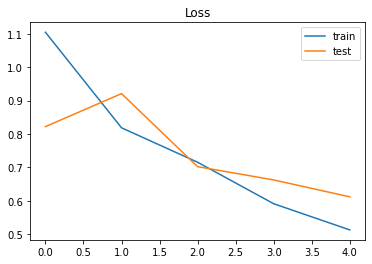

In [23]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

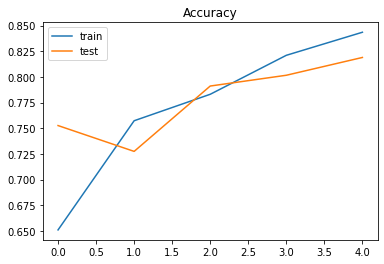

In [27]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

Test with a new consumer complaint

In [28]:
import numpy as np
new_complaint = ['I am a victim of identity theft and someone stole my identity and personal information to open up a Visa credit card account with Bank of America. The following Bank of America Visa credit card account do not belong to me : XXXX.']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['Credit reporting, credit repair services, or other personal consumer reports', 'Debt collection', 'Mortgage', 'Credit card or prepaid card', 'Student loan', 'Bank account or service', 'Checking or savings account', 'Consumer Loan', 'Payday loan, title loan, or personal loan', 'Vehicle loan or lease', 'Money transfer, virtual currency, or money service', 'Money transfers', 'Prepaid card']
print(pred, labels[np.argmax(pred)])

[[3.5479125e-02 3.6069911e-02 4.9992043e-01 3.4831482e-01 7.0890553e-02
  2.7344917e-04 7.0431330e-03 4.6448718e-04 1.0672034e-03 4.7685998e-04]] Mortgage


Credits: towardsdatascience.com